In [3]:
from transformers import ViTImageProcessor, ViTForImageClassification
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms


# processor = ViTImageProcessor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')

model.eval() # for evaluation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Creating an input
mean = 0.5
std = 0.5
input = mean + std*torch.randn((3,224,224)) # should be of size 3,224,224
input_batch = input.unsqueeze(0)

input_batch.requires_grad_()

# Functions that help with visualization
def norm_01(array):
    return(array-np.min(array))/(np.max(array)-np.min(array))

def show_im(batch):
    img = batch.reshape(3,224,224).permute(1,2,0)
    img_np = img.detach().numpy()
    plt.imshow(norm_01(img_np))

# outputs = model(input)
# print(outputs.logits[0,1])
# outputs.logits[0,1].backward()
# print(input.grad)


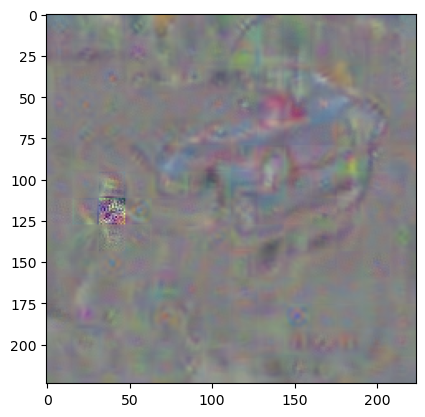

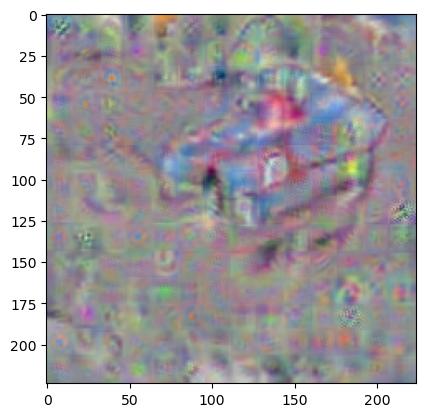

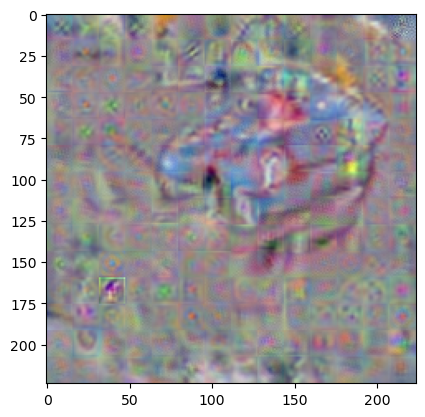

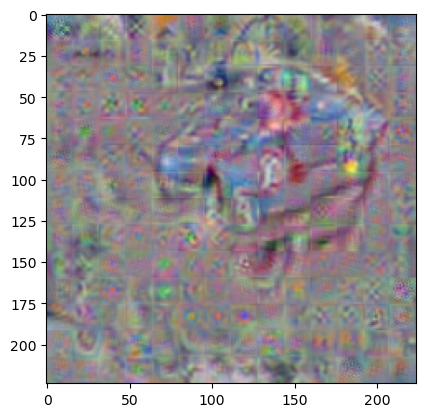

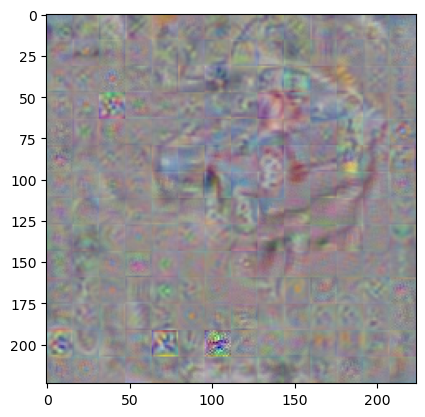

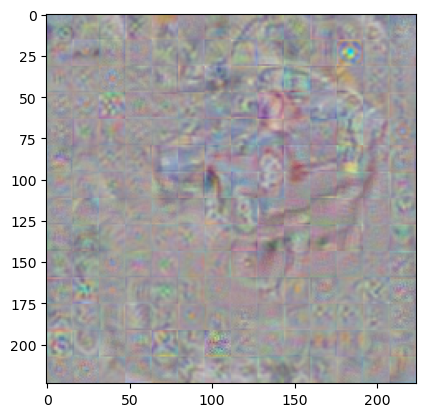

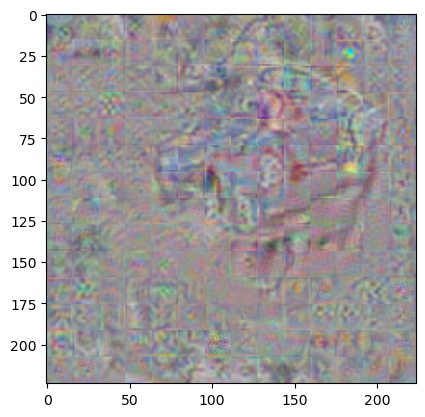

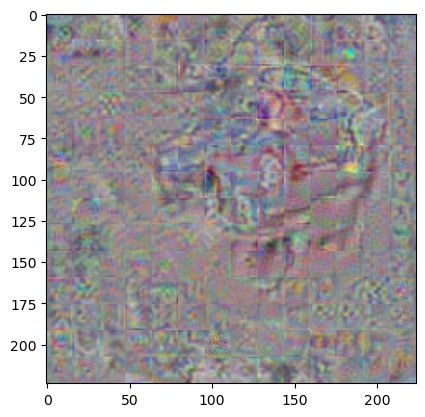

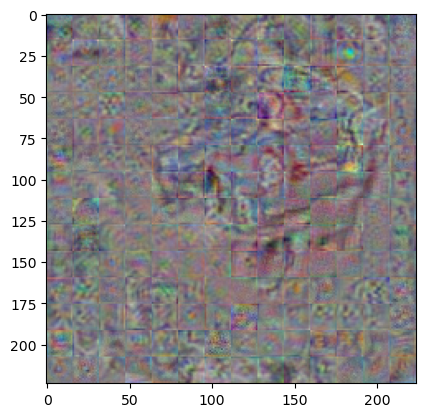

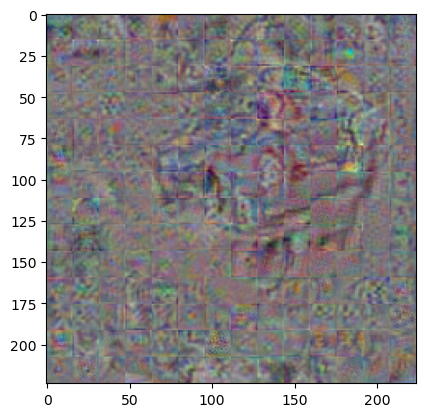

In [5]:
# Class I want to optimize
idx = 4 # 0: airplanes, 1: cars, 2: birds, 3: cats, 4: deer, 5: dogs, 6: frogs, 7: horses, 8: ships, 9: trucks


epochs = 1000
start_step_size = 0.01
end_step_size = 0.01


start_sig = 0.5 #was 1 Having a decaying sigma seems to yield better results
end_sig = 0.05 
jitter = 0 # Jitter doesn't seem to help too much
theta_decay = 0.01 # Theta decay seems to help (0.02 seems good)

num_im_save = 10

checkpoints = []

for epoch in range(epochs):
  
  model.zero_grad()
  if input_batch.grad != None:
    input_batch.grad.zero_()
  y_pred = model.forward(input_batch)

  y_pred.logits[0,1].backward()

  g = input_batch.grad
  #ox, oy = np.random.randint(-jitter, jitter+1, 2)
  
  with torch.no_grad():

    step_size = start_step_size + ((end_step_size - start_step_size) * epoch) / epochs
    input_batch += step_size/np.abs(g).mean() * g

    # input_batch = input_batch.roll( ox, -1) # apply jitter shift
    # input_batch = input_batch.roll( oy, -2)

    #input_batch = input_batch.mul((1.0 - theta_decay)) # weight decay

    sig = start_sig + ((end_sig - start_sig) * epoch) / epochs
    blurrer = transforms.GaussianBlur(kernel_size=5, sigma=sig)
    input_batch = blurrer(input_batch)    

  input_batch.requires_grad_()

  if (epoch+1) % (epochs/num_im_save) == 0:
    checkpoints.append(input_batch)
    show_im(input_batch)
    plt.show()



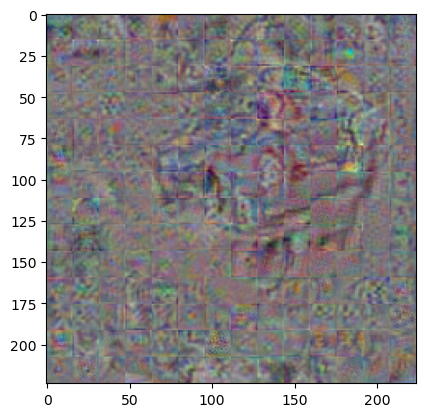

In [7]:
checkpoint_num = 9

show_im(checkpoints[checkpoint_num])

In [24]:
from PIL import Image
import os

img = checkpoints[checkpoint_num].reshape(3, 224, 224).permute(1, 2, 0)
img_np = img.detach().numpy()
arr = norm_01(img_np) * 255
im = Image.fromarray(arr.astype(np.uint8))

output_directory = './Imgs_ViT/'
output_filename = f'class_{idx}_lr_0.01.jpg'
output_path = os.path.join(output_directory, output_filename)

if os.path.exists(output_directory):
    print("Directory exists.")
else:
    print("Directory does not exist. Creating...")
    os.makedirs(output_directory)

if os.path.isfile(output_path):
    print("File already exists. Change the name.")
else:
    im.save(output_path)
    print(f"Image saved to: {output_path}")


Directory exists.
File already exists. Change the name.


In [12]:
# print(input)
# print(processed_inputs)
# preprocess = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 5, 0.5])
# preprocess_inputs = preprocess(input)
# print(preprocess_inputs)
print(processor.do_rescale)

True


In [5]:
import numpy as np

im = np.array(image)
print(im.shape)

(32, 32, 3)


In [27]:
print(inputs['pixel_values'].shape)
print(processor)

torch.Size([1, 3, 224, 224])
ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

